# Training a GNN: Node level pred
Parameters of simualation:  
* Domain size = 6*6
* signal size = 10
* number station = 5-15

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import torch
import torch_geometric
from torch_geometric.transforms import KNNGraph
from torch_geometric.data import InMemoryDataset, Data
from torch.nn import Linear, Parameter, LeakyReLU, Conv2d, MaxPool1d
from torch_geometric.nn import GCNConv, MessagePassing, MLP
from scipy.spatial import distance
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm

In [2]:
def visualize_graph_torch(g, color):
    fig, ax = plt.subplots(figsize=(6,6))
    # add edges
    for edge in g.edge_index.T:
        ax.plot([g.pos[edge[0]][0], g.pos[edge[1]][0]], [g.pos[edge[0]][1], g.pos[edge[1]][1]], color='Blue', linewidth=1)
    scatter = ax.scatter(x=g.pos.T[0], y=g.pos.T[1], alpha=1, c=g[color][:,0], s=150)
    legend1 = ax.legend(*scatter.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
    plt.show()

In [3]:
SIGNAL_SIZE = 10
#NB_NODES = 50
NB_GRAPHS = 10

In [4]:
def add_edge_weight(g):
    edge_weight = []
    for edge in g.edge_index.T:
        edge_weight.append(1/(distance.euclidean((g.pos[edge[0]][0], g.pos[edge[0]][1]), (g.pos[edge[1]][0], g.pos[edge[1]][1]))+1))
    g.edge_weight = torch.tensor(np.array(edge_weight)).type(torch.FloatTensor)
    return g

In [7]:
class SinDataset(InMemoryDataset):

    def __init__(self, root, transform=None, pre_transform=None, nb_graph=10):
        self.nb_graph = nb_graph
        super(SinDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        # List of the raw files
        return 0

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        # Read the file netcdf and create dataset
        data_list = []

        for graph in range(self.nb_graph):
            
            nb_nodes = np.random.randint(5, 15)
            pos = torch.tensor(np.array(np.random.uniform(low=0, high=6, size=nb_nodes*2)).reshape(-1, 2)).type(torch.FloatTensor)        
        
            # create signal
            sin = []
            origin = np.random.randint(0, 6, size=2)
            for i in range(nb_nodes):
                dist = distance.euclidean(origin, (pos[i][0], pos[i][1]))
                sin.append(np.sin(np.arange(dist, dist+SIGNAL_SIZE)[:SIGNAL_SIZE]))
            signal = torch.tensor(np.array(sin)).type(torch.FloatTensor).reshape(-1, SIGNAL_SIZE)
        
            # create the n different graphs based on mask
            for i in range(nb_nodes):
                g = Data(pos=pos, signal=signal)
                mask = torch.tensor(np.zeros(nb_nodes)).type(torch.BoolTensor)
                mask[i] = True
                g.train_mask = mask
                data_list.append(g)
            
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
            data_list = [add_edge_weight(data) for data in data_list]
        

        # Store the processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [8]:
dataset = SinDataset(root="./sin_train_masked", pre_transform=KNNGraph(k=5, loop=False, force_undirected=True), 
                       nb_graph=NB_GRAPHS)
dataset

SinDataset(85)

In [9]:
data = dataset[0]
data

Data(pos=[14, 2], signal=[14, 10], train_mask=[14], edge_index=[2, 86], edge_weight=[86])

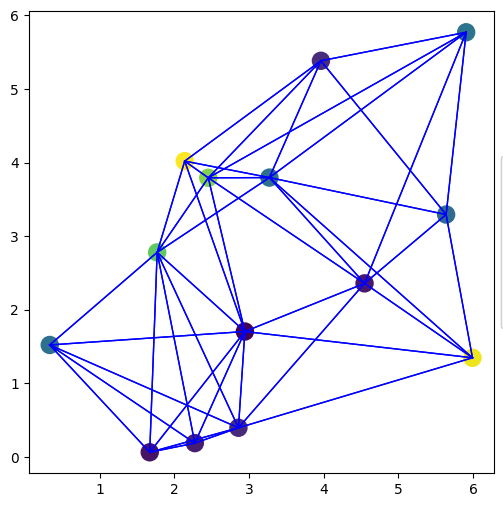

In [10]:
visualize_graph_torch(data, color='signal')

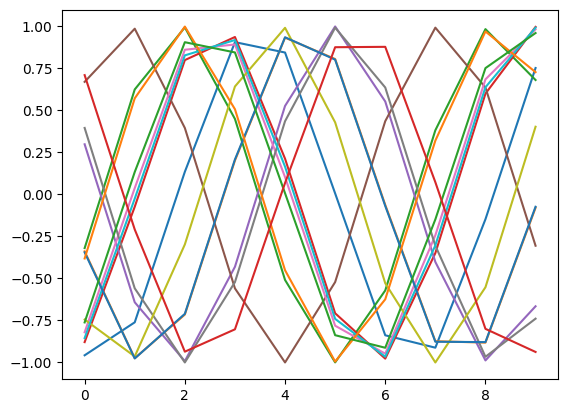

In [11]:
for i in range(data.signal.shape[0]):
    plt.plot(data.signal[i], label=i)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
class BasicNet(torch.nn.Module):
    """
    BasicNet is a Graph Convolutional Network (GCN) model with a Multi-layer Perceptron (MLP) structure.
    Arguments:
        channels_x (int): The number of features in the node feature matrix `x`.
        channels_y (int): The number of features in the node feature matrix `y`.
        hidden_channels (int, optional): The number of hidden channels in GCNConv layer. Default: 10.
        dropout (float, optional): The dropout rate to be applied to the MLP layers. Default: 0.3.

    Attributes:
        conv (GCNConv): A graph convolutional layer.
        mlp_in (MLP): The input MLP that transforms the concatenation of `x` and `signal` into hidden representation.
        mlp_out (MLP): The output MLP that transforms the hidden representation from `mlp_in` into final node feature matrix `y`.
    """
    def __init__(self, channels_x, channels_y, hidden_channels=10, dropout=0.3):
        super(BasicNet, self).__init__()
        torch.manual_seed(1234)
        channels_extr = channels_y
        self.pooling = MaxPool1d(2)
        self.feature_extraction1 = Conv2d(1, 2, (1, 3), padding=(0, 1))
        self.feature_extraction2 = Conv2d(2, 2, (1, 3), padding=(0, 1))
        self.feature_extraction3 = Conv2d(2, 2, (1, 3), padding=(0, 1))
        channels_extr = channels_extr*8//pow(2, 3) #channels input*nb channels last conv /2^nb pooling for kernel 2
        
        self.mlp_in = MLP([channels_extr+channels_x, hidden_channels])
        # self.mlp_in = MLP([channels_y+channels_x, hidden_channels])
        self.conv = GCNConv(hidden_channels, hidden_channels)
        self.mlp_out = MLP([hidden_channels, 256, 256, channels_y])

    
    def forward(self, x, signal, edge_index, edge_weight, mask):
        """
        Perform a forward pass through the network.

        Arguments:
            x (torch.Tensor): Node feature matrix with shape `(num_nodes, channels_x)`.
            signal (torch.Tensor): Node feature matrix with shape `(num_nodes, channels_y)`.
            edge_index (torch.Tensor): Edge indices with shape `(2, num_edges)`.
            edge_weight (torch.Tensor): Edge weight with shape `(num_edges,)`.
            mask (torch.Tensor): Mask indicating which nodes to use for training with shape `(num_nodes,)`.

        Returns:
            torch.Tensor: The final node feature matrix `y` with shape `(num_nodes, channels_y)`.
        """
        signal = (signal.T*(~mask)).T
        signal = self.feature_extraction1(signal.reshape(1, signal.shape[0], signal.shape[1]))
        signal = self.pooling(signal)
        # signal = self.feature_extraction2(signal)
        # signal = self.pooling(signal)
        # signal = self.feature_extraction3(signal)
        # signal = self.pooling(signal)
        signal = torch.flatten(torch.permute(signal, (1, 0 ,2)), start_dim=1)
        # out = signal
        out = torch.cat([x, signal], dim=-1)
        out = self.mlp_in(out)
        out = self.conv(out, edge_index, edge_weight)
        # out = self.conv2(out, edge_index, edge_weight)
        out = self.mlp_out(out)
        return out.tanh()
    
model = BasicNet(data.pos.shape[1], data.signal.shape[1], hidden_channels=128)
print(model)

BasicNet(
  (pooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (feature_extraction1): Conv2d(1, 2, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (feature_extraction2): Conv2d(2, 2, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (feature_extraction3): Conv2d(2, 2, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (mlp_in): MLP(12, 128)
  (conv): GCNConv(128, 128)
  (mlp_out): MLP(128, 256, 256, 10)
)


In [14]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(dataset, train_size=0.5, random_state=42)
val_dataset, test_dataset = train_test_split(val_dataset, train_size=0.8, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"nb graph train ds= {len(train_dataset)}, nb graph val ds= {len(val_dataset)}")

nb graph train ds= 42, nb graph val ds= 34


In [15]:
data = train_dataset[0]
data

Data(pos=[14, 2], signal=[14, 10], train_mask=[14], edge_index=[2, 86], edge_weight=[86])

In [16]:
import numpy as np
import torch

class EarlyStopper:
    """
    A class for early stopping the training process when the validation loss stops improving.
    
    Parameters:
    -----------
    patience : int, optional (default=1)
        The number of epochs with no improvement in validation loss after which training will be stopped.
    min_delta : float, optional (default=0)
        The minimum change in the validation loss required to qualify as an improvement.
    """
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        """
        Check if the training process should be stopped.
        
        Parameters:
        -----------
        validation_loss : float
            The current validation loss.
            
        Returns:
        --------
        stop : bool
            Whether the training process should be stopped or not.
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    

def train(dataloader, device):
    """
    Train the model on a given dataloader.
    
    Parameters:
    -----------
    dataloader : DataLoader
        A PyTorch DataLoader containing the training data.
        
    Returns:
    --------
    mean_loss : float
        The mean loss over all batches in the dataloader.
    """
    model.train()
    mean_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()  # Clear gradients.
        out = model(batch.pos, batch.signal, batch.edge_index, batch.edge_weight, batch.train_mask)  # Perform a single forward pass.
        loss = criterion(out[batch.train_mask], batch.signal[batch.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        mean_loss += loss
    return float(mean_loss/len(dataloader))


@torch.no_grad()
def validation(dataloader, device):
    """
    Compute the validation loss on a given dataloader.
    
    Parameters:
    -----------
    dataloader : DataLoader
        A PyTorch DataLoader containing the validation data.
        
    Returns:
    --------
    mean_loss : float
        The mean loss over all batches in the dataloader.
    """
    model.eval()
    loss = 0
    for data in dataloader:
        data = data.to(device)
        out = model(data.pos, data.signal, data.edge_index, data.edge_weight, data.train_mask)
        loss += criterion(out[data.train_mask], data.signal[data.train_mask])
    return float(loss/len(dataloader))

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


model = BasicNet(data.pos.shape[1], data.signal.shape[1], hidden_channels=128).to(device)

criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define optimizer.
early_stopper = EarlyStopper(patience=20, min_delta=0.0)
print(device)

cpu


In [18]:
model

BasicNet(
  (pooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (feature_extraction1): Conv2d(1, 2, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (feature_extraction2): Conv2d(2, 2, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (feature_extraction3): Conv2d(2, 2, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (mlp_in): MLP(12, 128)
  (conv): GCNConv(128, 128)
  (mlp_out): MLP(128, 256, 256, 10)
)

In [19]:
import time
loss_train = []
loss_val = []
best_loss = 1
best_epoch = 0
PATH_CHECKPOINT = "./checkpoint/best_masked.pt"
start_time = time.perf_counter()

nb_epoch = tqdm(range(5000))

for epoch in nb_epoch:
    loss_train.append(train(train_loader, device))
    loss_val.append(validation(val_loader, device))
    
    if loss_val[-1] < best_loss:
        best_loss = loss_val[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), PATH_CHECKPOINT)
    if early_stopper.early_stop(loss_val[-1]):
        print(f"early stopping at epoch {epoch}: train loss={loss_train[-1]}, val loss={loss_val[-1]}")
        break
    nb_epoch.set_postfix_str(f"train loss={loss_train[-1]}, val loss={loss_val[-1]}")
    # if epoch % 50 == 0:
    #     total_time = time.perf_counter()-start_time
    #     print(f"Epoch {epoch}: train loss={loss_train[-1]}, val loss={loss_val[-1]}, time per epoch={total_time/50:0.4f} seconds")
    #     start_time = time.perf_counter()

  2%|▎                  | 78/5000 [00:07<08:15,  9.94it/s, train loss=0.09822165966033936, val loss=0.3268299996852875]

early stopping at epoch 78: train loss=0.09671168774366379, val loss=0.32835304737091064


In [20]:
# restore best model
PATH_CHECKPOINT = "./checkpoint/best_masked.pt"
model.load_state_dict(torch.load(PATH_CHECKPOINT))
print(f"best loss={best_loss}, model eval loss={validation(test_dataset, device)} at epoch {best_epoch}")

best loss=0.3240234851837158, model eval loss=0.4523429274559021 at epoch 58


In [21]:
data = test_dataset[0]
model = model.to('cpu')
data.out = model(data.pos, data.signal, data.edge_index, data.edge_weight, torch.tensor(np.zeros([data.signal.shape[0]])).type(torch.BoolTensor)).detach()
data.out.shape

torch.Size([9, 10])

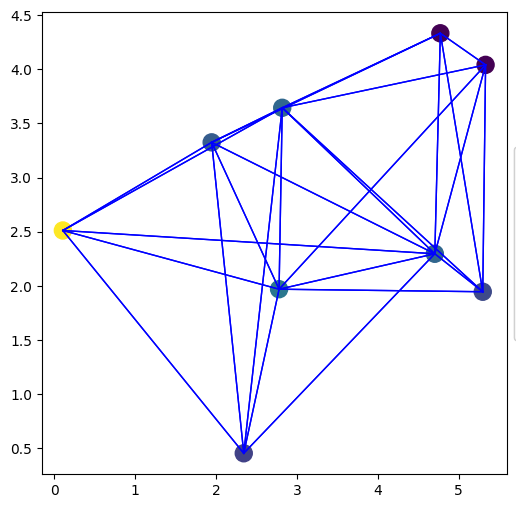

In [22]:
data.error = np.abs(data.signal.detach()-data.out.detach()).sum(axis=1).reshape(data.signal.shape[0],1)
visualize_graph_torch(data, color="error")

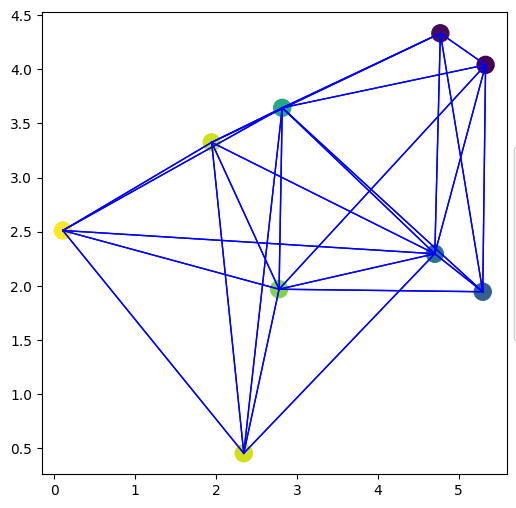

In [23]:
visualize_graph_torch(data, color="out")

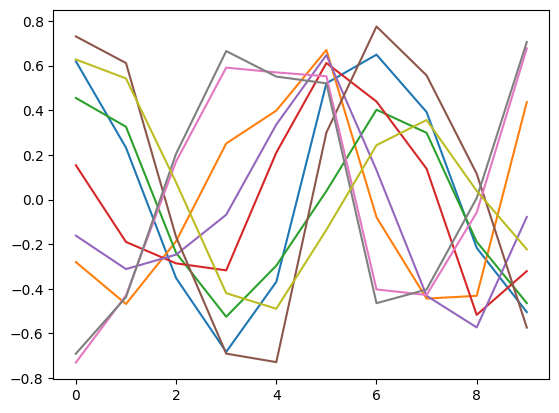

In [24]:
for i in range(data.signal.shape[0]):
    plt.plot(data.out[i], label=i)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-1.1, 1.1)

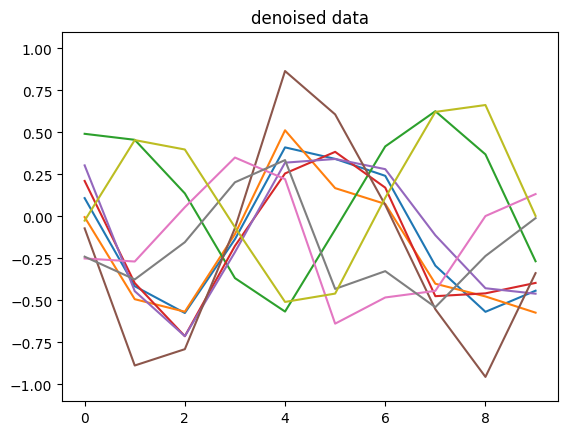

In [25]:
for i in range(data.signal.shape[0]):
    plt.plot(data.signal[i]-data.out[i], label=i)
    #plt.plot(data.signal[i])
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("denoised data")
plt.ylim(-1.1, 1.1)

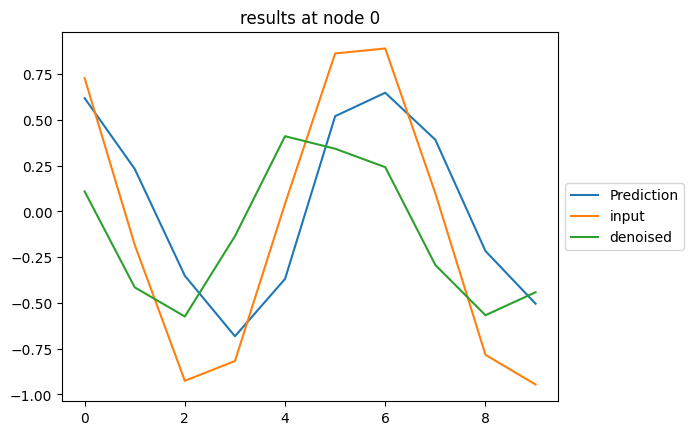

In [26]:
test_node = test_dataset[0].train_mask.nonzero()[0][0]
plt.title(f"results at node {test_node}")
plt.plot(data.out[test_node][:50], label="Prediction")
plt.plot(data.signal[test_node][:50], label="input")
plt.plot(data.signal[test_node][:50]-data.out[test_node][:50], label="denoised")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

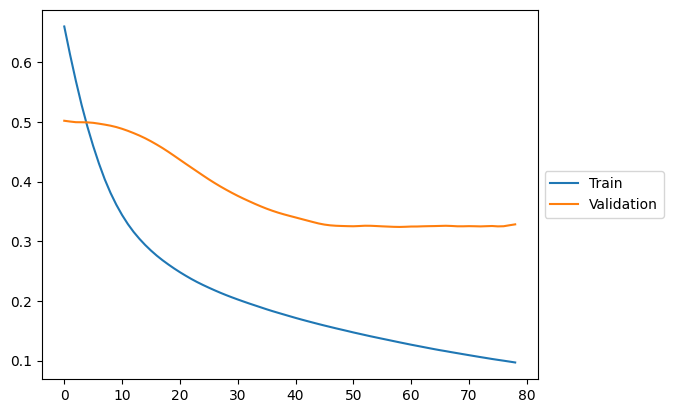

In [27]:
plt.plot(loss_train, label="Train")
plt.plot(loss_val, label = "Validation")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))